# Reinforcement Learning 2023 KHU

Policy Gradient
- REINFORCE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'/RL/PG
!ls
import sys; sys.path.append('..') # add project root to the python path

In [ ]:
!pip install swig
!pip install gym[all]
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np
from collections import deque

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io


import time

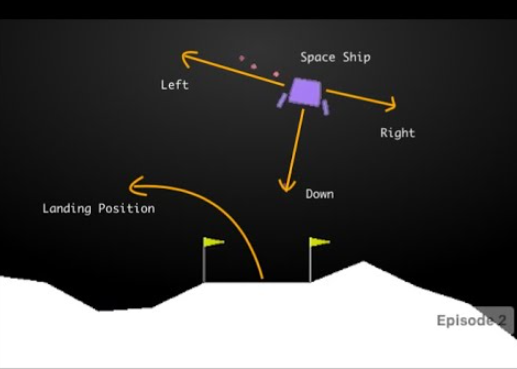

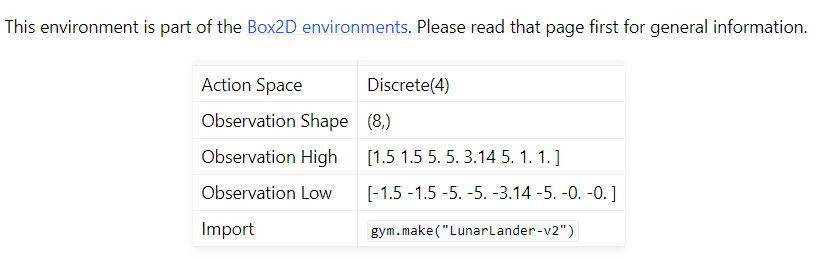

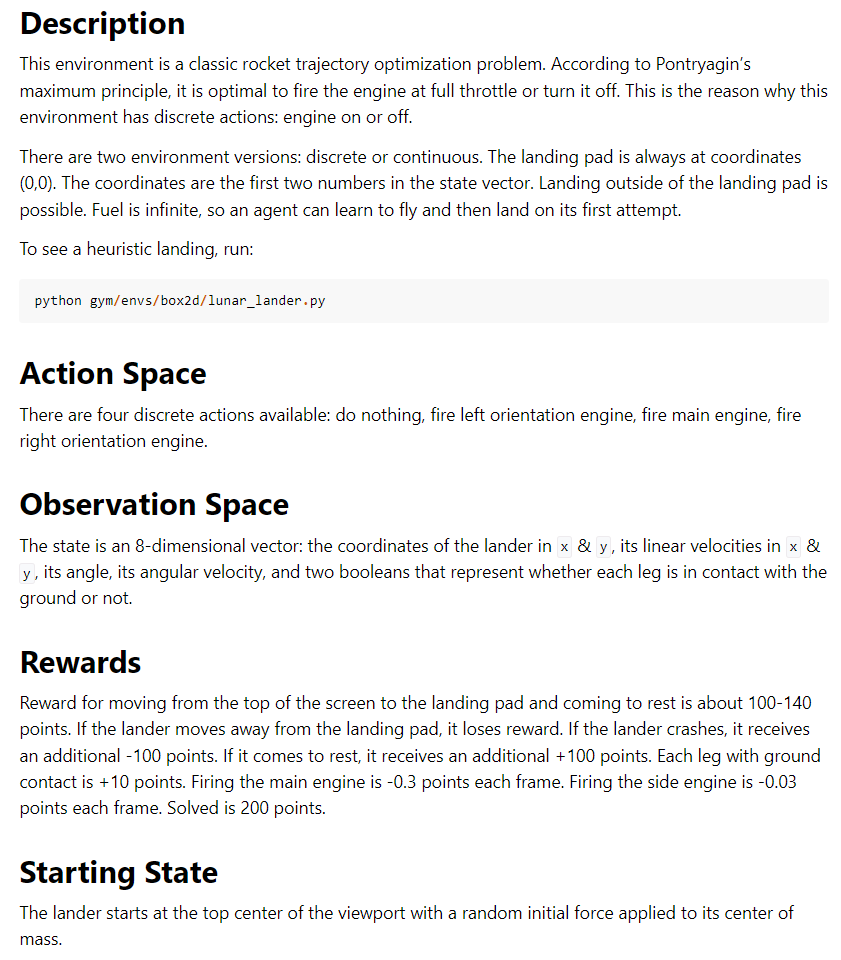

In [ ]:
env = gym.make('LunarLander-v2')

In [ ]:
class Policy(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim):
    super(Policy,self).__init__()

    self.fc1=nn.Linear(input_dim,hidden_dim)
    self.fc2=nn.Linear(hidden_dim,hidden_dim)
    self.output=nn.Linear(hidden_dim,output_dim)

  def forward(self,x):

    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=F.softmax(self.output(x),dim=-1)

    return x

In [ ]:
INPUT_DIM = env.observation_space.shape[0]
HIDDEN_DIM = 256
OUTPUT_DIM = env.action_space.n

policy = Policy(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
optimizer = optim.Adam(policy.parameters(), lr = 0.0005)

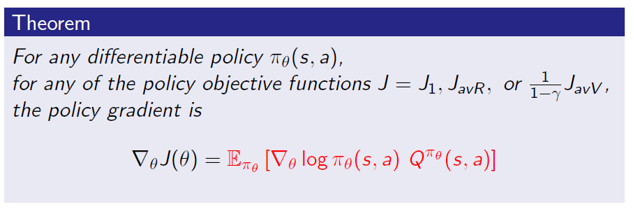

In [ ]:
def train(env,policy,optimizer,gamma):

    policy.train()
    done=False
    state = env.reset()

    episode_reward=0
    state_list=[]
    action_list=[]
    reward_list=[]

    while not done:
        action_probs=policy(torch.FloatTensor(state))
        action_probs=action_probs.detach().cpu().numpy()
        action = np.random.choice(np.arange(OUTPUT_DIM), p=action_probs)

        next_state,reward,done,_=env.step(action)

        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward)

        episode_reward += reward

        # too bad result can make training unstable.
        if episode_reward < -250:
            done = 1

        state=next_state

    # Calculate Returns
    R=0.
    return_array=np.zeros((len(reward_list)))

    for i in range(len(reward_list)-1,-1,-1):
        R=reward_list[i]+R*gamma
        return_array[i]=R

    # We normalize returns for stable training. (This is implemental trick, not Policy Gradient)
    return_array=(return_array-np.mean(return_array))/np.std(return_array)

    # Create Tensor
    state_t=torch.FloatTensor(state_list)
    action_t=torch.LongTensor(action_list).view(-1,1)
    return_t=torch.FloatTensor(return_array).view(-1,1)

    # Get log(pi(a_t|s_t))
    action_probs=policy(state_t).gather(1,action_t)
    log_action_probs=torch.log(action_probs)

    loss=-torch.mean(log_action_probs*return_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return episode_reward

In [ ]:
MAX_EPISODES = 5000
gamma = 0.99
interval = 10
scores=[]
scores_window=deque(maxlen=interval)

start=time.time()

for episode in range(1, MAX_EPISODES+1):

    episode_reward = train(env, policy, optimizer, gamma)


    scores.append(episode_reward)
    scores_window.append(episode_reward)


    if episode % interval == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
    if episode_reward>=200.0:
        print("END!!")
        print("It takes {} seconds".format(time.time()-start))
        torch.save(policy.state_dict(), 'checkpoint.pth')
        break

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
!mkdir video
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(policy, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    policy.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()

        action_probs=policy(torch.FloatTensor(state))
        action_probs=action_probs.detach().cpu().numpy()
        action = np.random.choice(np.arange(OUTPUT_DIM), p=action_probs)

        state, reward, done, _ = env.step(action)

    env.close()

In [ ]:
show_video_of_model(policy, 'LunarLander-v2')

In [ ]:
show_video('LunarLander-v2')